# Homework2 of Deep RL, KIT, 2021-22 WS (15Pts)

Designed by Ge Li, ge.li@kit.edu, inspired by the official PyTorch DQN
implementation and the RL Stable Baseline library.

All homeworks are self-contained. They can be completed in their respective notebooks.
To edit and re-run code, you can therefore simply edit and restart the code cells below.
There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window).
This file should automatically be synced with your Google Drive. We also save all recordings and logs in it by default so that you won't lose your work in the event of an instance timeout.
 However, you will need to re-mount your Google Drive and re-install packages with every new instance.

In [ ]:
# Your work will be stored in a folder called `drl_ws21` by default to prevent Colab
# instance timeouts from deleting your edits.
# We do this by mounting your google drive on the virtual machine created in this colab
# session. For this, you will likely need to sign in to your Google account and copy a
# passcode into a field below

import os
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Create paths in your google drive
DRIVE_PATH = '/content/gdrive/My\ Drive/drl_ws21'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
    % mkdir $DRIVE_PATH

# the space in `My Drive` causes some issues,
# make a symlink to avoid this
SYM_PATH = '/content/drl_ws21'
if not os.path.exists(SYM_PATH):
    !ln -s $DRIVE_PATH $SYM_PATH
% cd $SYM_PATH

/content/gdrive/My Drive/drl_ws21


In [ ]:
# Install **python** packages
#  " > /dev/null 2>&1" means do not print any output

!pip install matplotlib > /dev/null 2>&1
!pip install stable-baselines3[extra] > /dev/null 2>&1
!pip install unrar > /dev/null 2>&1

In [ ]:
# Install **system** packages
!apt update > /dev/null 2>&1
!apt install -y --no-install-recommends xvfb python-opengl ffmpeg > /dev/null 2>&1

In this homework, we are going to implement the Deep Q-Network algorithm and
apply it to the Atari 2600 game "Breakout". Atari was a popular game console
during the 1980s, and Breakout is a game where few layers of bricks line the
top of the screen and the goal is to destroy them all by repeatedly bouncing
a ball off a paddle into them.
Refer to <https://en.wikipedia.org/wiki/Breakout_(video_game)> for more details.


OpenAI gym's Atari environment is used to simulate the game.
In this homework, we simulate the original game console behaviour using all **4**
 game console buttons, with actions: **LEFT**, **RIGHT** and **RESTART** (when
 game over). The 4th button is useless in Breakout. The player starts each game with
  5 lives, and loses a life whenever they miss an incoming ball. The player
  gets one point per brick that they hit with the ball, after which this brick is
  destroyed.
  If the player loses all 5 lives, the game will be over. Then, only
  when the "RESTART" button is pressed, the game will be restarted again.
  The final score for each game is the accumulated score of all 5 lives.

We start by importing all the necessary python modules and defining some helper
functions which you do not need to change. Still, make sure you are aware of
what they do.

In the following blocks, you will see:
 * Import statements and download game files
 * Utilities (PyTorch GPU, plotting functions, image pre-processes)
 * Environment setup and Gym state wrappers
 * Runtime arguments
 * Functional code (classes, functions, ...) and explanations:
    * Function to update exploration rate
    * Class definition of Transition and ReplayMemory (Buffer)
    * Q network defined by PyTorch with CNN and FC layers
    * **Function to select action (Your job!!!)**
    * **Function to optimize the policy network (Your job!!!)**
    * **Main loop containing rollouts, network update, as well as
    post-processing (Your job!!!)**

In [ ]:
# Imports and utility
# DO NOT CHANGE THIS BLOCK!
# DO NOT CHANGE THIS BLOCK!
# DO NOT CHANGE THIS BLOCK!

# Notebook utility for clear all output
from IPython.display import clear_output

# Some Python Buildin packages for random number and containers
import random
from collections import deque
from collections import namedtuple

# Progress bar
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt

# Although we use Deep Learning, we still need to use some CPU memory for the
# Replay Buffer, since Image data normally takes a lot of space and GPU memory
# is more expensive than CPU memory
import numpy as np

# Deep Learning Platform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# We use stable baseline to pre-process our Atari game data
# detail Stable Baseline is a RL benchmark library with plenty of Algorithms,
# here we borrow their wrappers for data preprocessing and video recording
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.vec_env import VecVideoRecorder

# Download Atari game files
import urllib.request

urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar',
                           'Roms.rar')
!unrar x Roms.rar > /dev/null 2>&1
!mkdir rars > /dev/null 2>&1
!mv HC\ ROMS.zip   rars > /dev/null 2>&1
!mv ROMS.zip  rars > /dev/null 2>&1
!python -m atari_py.import_roms rars > /dev/null 2>&1

# Set random seeds
np.random.seed(0)
torch.manual_seed(0)
env_seed = 0

# Use GPU to speed up your training
# detail: the code below will detect the hardware you have and set the
# device to Nvidia "cuda" instead of "cpu".

#assert torch.cuda.is_available(), "To save your time, please use cuda! Change your Colab settings to use GPU."
#device = torch.device("cuda")
device = torch.device("cpu")

def show_img(state):
    """
    This is a helper function to plot the environment state.
    Args:
        state: environment state

    Returns:
        None
    """
    if isinstance(state, np.ndarray):
        state_numpy = state[0]
    elif isinstance(state, torch.Tensor):
        state_numpy = state[0].cpu().numpy()
    else:
        raise NotImplementedError
    fig = plt.figure()
    for i in range(4):
        fig.add_subplot(2, 2, i + 1)
        plt.imshow(state_numpy[..., i])
    plt.show()


def normalize(data):
    """
    Image Normalizer, normalize image data from the range [0, 255] to [0, 1]

    Args:
        data: integer data in either tensor or Numpy array, bounded by [0, 255]

    Returns:
        Float data bounded by [0, 1]
    """
    return data / 255.0


def show_avg_reward(list_num_game, list_avg_game_score):
    """
    Plot average game score
    Args:
        list_num_game: x axis for different number of games
        list_avg_game_score: y axis for average game scores

    Returns:
        None
    """
    clear_output(True)
    plt.figure()
    plt.plot(list_num_game, list_avg_game_score)
    plt.xlabel("Num of games")
    plt.ylabel("Avg_game_score")
    plt.show()

## Environment setup
Get our environment and use some helper wrappers to pre-process the data.
The wrapper will return **a 4-frames-long game screenshots sequence** as a game
state.
For more preprocessing details, please refer:
<https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/>

In [ ]:
# DO NOT CHANGE THIS BLOCK!
# DO NOT CHANGE THIS BLOCK!
# DO NOT CHANGE THIS BLOCK!

env = make_atari_env('BreakoutDeterministic-v4', n_envs=1, seed=env_seed)
env = VecFrameStack(env, n_stack=4)
num_actions = env.action_space.n

# Wrap env into a video recorder, since we do not have a display in Colab, we 
# cannot render the game. Instead, we record a video of the game and save it
# to your Google Drive under "My Drive/drl_ws21//DQN/video"

# Record a 500 steps long video in every 50000 training steps
env = VecVideoRecorder(env, './DQN/video',
                       record_video_trigger=lambda x: x % 50000 == 0,
                       video_length=500,
                       name_prefix="DQN_Atari")

## Initialize Runtime arguments and (hyper-)parameters
Click and see details

In [ ]:
# DO NOT CHANGE THIS BLOCK!
# DO NOT CHANGE THIS BLOCK!
# DO NOT CHANGE THIS BLOCK!

class Args:
    """
    Boilerplate for properly accessing the args
    """

    def __getitem__(self, key):
        return getattr(self, key)

    def __setitem__(self, key, val):
        setattr(self, key, val)

    BATCH_SIZE = 32  #@param {type: "int"}, mini batch size
    GAMMA = 0.99  #@param {type: "float"}, discount factor
    EPS_START = 1.0  #@param {type: "float"}, exploration rate at the start
    EPS_END = 0.05  #@param {type: "float"}, minimum exploration rate

    EPS_FRACTION = 0.1  #@param {type: "float"}, exploration rate decreases
    # during the first X% of the entire training process

    TARGET_UPDATE_INTERVAL = 10000  #@param {type: "int"}, interval of
    # updating the target network

    LEARNING_RATE = 1e-4  #@param {type: "float"}, learning rate
    BUFFER_SIZE = 100000  #@param {type: "int"}, replay buffer size
    TOTAL_STEPS = 500000  #@param {type: "int"}, total time steps for training

    MAX_GRAD_NORM = 10  #@param {type: "int"}, when do back-propagation, clip
    # the gradient if it is greater than this value

    TRAIN_FREQ = 4  #@param {type: "int"}, Optimize the NN after X-times of
    # rollouts

    NUM_ACTIONS = num_actions  #@param {type: "int"}, number of actions


# Instantiate
args = Args()

## Update exploration rate
The exploration rate will decrease from 1 to 0.05 during the first 10% of the
 training steps

In [ ]:
# DO NOT CHANGE THIS BLOCK!
# DO NOT CHANGE THIS BLOCK!
# DO NOT CHANGE THIS BLOCK!

def update_eps(total_time_steps):
    """
    This is a helper function to update exploration rate, the exploration rate
    will decrease from 1 to 0.05 during the first 10% of the training steps

    Args:
        total_time_steps: total time steps from the start of the training

    Returns:
        eps: exploration rate

    """
    return max(args.EPS_START - total_time_steps / (args.TOTAL_STEPS *
                                                    args.EPS_FRACTION),
               args.EPS_END)


## Transition and ReplayMemory (buffer)

In [ ]:
# DO NOT CHANGE THIS BLOCK!
# DO NOT CHANGE THIS BLOCK!
# DO NOT CHANGE THIS BLOCK!

# Definition of transition stored by the reply buffer
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):
    """
    Definition of reply buffer used by DQN
    """

    def __init__(self, capacity):
        """Initialize the ReplayMemory with certain capacity"""
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """
        Sample transitions and transfer them from numpy array to PyTorch tensor
        Args:
            batch_size: mini batch size

        Returns:
            5 batches data
        """
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # a detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*random.sample(self.memory, batch_size))) 
        #print("batch:",batch)
        #random.sample():returns a particular length list of items chosen from the sequence i.e. list, tuple, string or set. Used for random sampling without replacement.

        # Get each individual batch prepared
        # :transfer them from numpy array to PyTorch tensor
        done_b = torch.tensor(np.concatenate(batch.done), device=device,
                              dtype=torch.bool).squeeze(-1)
        state_b = torch.tensor(np.concatenate(batch.state),
                               device=device, dtype=torch.float)
        next_state_b = torch.tensor(np.concatenate(batch.next_state),
                                    device=device, dtype=torch.float)
        action_b = torch.tensor(np.concatenate(batch.action), device=device)
        reward_b = torch.tensor(np.concatenate(batch.reward),
                                device=device).squeeze(-1)
        # print("state_b.shape:",state_b.shape)
        # print("batch.state",batch.state)
        # print("np.concatenate(batch.state)",np.concatenate(batch.state))
        return state_b, action_b, next_state_b, reward_b, done_b

    def __len__(self):
        """Length of the ReplayMemory"""
        return len(self.memory)


# Instantiate
memory = ReplayMemory(args.BUFFER_SIZE)

## Deep Q-Network with CNN
In the following block, we define the DQN class. Each instance of this class
 is a Q network that computes the state action value function **Q(s, a)**.
The input of this Network is a state **s**, and the output is the value of
each action **a** given this state. Please note that for NN training, we
normally feed data in a mini-batch manner. Since each state in current task
is a 3rd order image tensor `(channel, height, width)`, the DQN expects input to be
a 4th order tensor with shape `(mini-batch, channel, height, width)`. And the
output is a 2nd order tensor with shape `(mini-batch, actions)`


In [ ]:
# DO NOT CHANGE THIS BLOCK!
# DO NOT CHANGE THIS BLOCK!
# DO NOT CHANGE THIS BLOCK!

class DQN(nn.Module):
    """
    Q-Network with CNN
    """

    def __init__(self, h, w, outputs):
        """
        Initialize the network, which contains 2D convolution layers (image
        process), Normalization layers (offer better numerical stability),
        and Fully Connected layers
        Args:
            h: height of the image in pixel
            w: width of the image in pixel
            outputs: number of actions
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        """
        Forward pass function, given a state s, compute value of all actions
        i.e. Q(s, a)
        Called with either one element to determine next action, or a batch
        during optimization.
        Args:
            x: state

        Returns:
            q_s_a = value of actions given this state
        """
        # Shape of x:
        # [batch_size or 1, height=84, width=84, channel=4]
        #
        # Shape of x after swapping the order of the data's axis:
        # [batch_size or 1, channel=4, height=84, width=84]
        #
        # Shape of q_s_a:
        # [batch_size or 1, num_actions=4]

        x = x.to(device)  # to GPU ????

        # Swap the order of the data's axis, from
        # [batch, height, width, channel] to [batch, channel, height, width]
        x = torch.einsum('...hwc->...chw', x)

        # Forward pass
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        q_s_a = self.head(x.reshape([x.size(0), -1]))
        # print("q_s_a size:", q_s_a.shape)
        return q_s_a


# Instantiate policy net and its optimizer, note we send the networks to GPU
policy_net = DQN(h=84, w=84, outputs=num_actions).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=args.LEARNING_RATE) #what for?

# Instantiate target net using NN parameters of the policy net
target_net = DQN(h=84, w=84, outputs=num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# We do not need any gradient from target net, turn it into evaluation mode
target_net = target_net.eval()

## Sample action using epsilon-greedy exploration method (3pts)

In the following block, you are going to select actions given a **state**
mini-batch and an exploration rate **eps**(ilon). Each action is an integer 0,
 1, 2 or 3.
The workflow is:
* Apply the epsilon-greedy method to decide if we go exploration or exploitation
* If exploitation, use the policy net to compute the **Q(s,a)** and select the
 action with the highest value.
* If exploration, randomly choose actions

Hints:
* The epsilon-greedy method can be achieved by an if-statement comparing eps
    with a random float bounded by [0, 1], try `random.random()` to get a random number.
* If exploitation, you do not need to compute gradient when you compute
    the **Q(s,a)** (think about why!), in this case you can use a context scope
    **with torch.no_grad():**. The operations in this scope will not contain
    any gradient information (computational graph).
* Before feed state into NN, call normalize() func to normalize it
* If exploitation, you can apply **argmax()** to get the action, which is
     the index of the max **Q(s,a)** along the action axis. You may need to
     use the arguments **dim** and **keepdim** to get the desired result.
* If exploration, randomly picking actions can be solved by generating a
    random index tensor. **torch.randint()** can help you. Be careful with
    the range and shape. As index in PyTorch, the data type **dtype** should be
    **torch.long**. And don't forget **device=device** to get a GPU tensor!


In [ ]:
# Finish the implementation!
# Finish the implementation!
# Finish the implementation!

def select_action(state: torch.Tensor, eps: float):
    """

    Args:
        state: state mini batch
        eps: exploration rate

    Returns:
        selected_actions: Discrete action tensor batch, each action is one
        integer from [0, 1, 2, 3]

    """

    # Shape of state:
    # [batch_size, height=84, width=84, num_channels=4]
    #
    # Shape of selected_actions:
    # [batch_size, 1]

    ## TODO ##
    ### Your code starts here ###
    if eps < random.random():
         # exploitation
         for i in range(state.shape[0]):
              state[i] = normalize(state[i])
         with torch.no_grad():
              action_vallist = policy_net.forward(state)
              selected_actions = torch.argmax(action_vallist,1,True)
              selected_actions = torch.tensor(selected_actions,dtype=torch.long,device=device)
              # print("\nselect_actions\n",selected_actions)
              # print("\nselect_actions.dtype\n",selected_actions.dtype)
    else:
         # exploration
         selected_actions = torch.zeros((state.shape[0],1),dtype=torch.long,device=device)
         for i in range(state.shape[0]):
             selected_actions[i] =  torch.randint(4,(1,),dtype=torch.long,device=device)
        #  selected_actions = torch.tensor(selected_actions,dtype=torch.long,device=device)
        #  print("\nselect_actions\n",selected_actions)
        #  print("\nselect_actions.dtype\n",selected_actions.dtype)
    ### Your code ends here ###

    # Some code to help check the validity of the output
    assert selected_actions.dtype == torch.long
    assert selected_actions.ndim == 2
    assert selected_actions.shape[0] == state.shape[0]
    assert selected_actions.shape[1] == 1

    return selected_actions

## Optimize the model (7Pts)

In the following block, you are going to optimize the parameters of the network.

The workflow is:
* Sample a mini batch from the replay buffer
* Compute an **unfinished masks batch** to distinguish if the $s'$ is terminal or
 not
* Use **Policy net** and index with action batch to compute $Q(s, a)$
* Compute $Q(s', a')$ using **Target net** if s' is not terminal state
* apply **max** operation to get the $\max_{a'} Q(s', a')$
* If s' is terminal states, simply set  $\max_{a'} Q(s', a')$ to 0
* Compute $r + \gamma~\max_{a'} Q(s', a')$
* Compute the Huber loss
* Update the NN parameters through Back-propagation

Hints:
* If **a** is a tensor, you can call **a.shape** to get its shape
* You can use torch.logical_not to compute **boolean not** operation
* Before you feed the state into the NN, call `normalize()` to normalize it
* To pick data from tensor A using tensor B as index, you can use **torch.gather()**
* To remove a size 1 dimension of an input tensor, use **torch.squeeze()**
* You can initialize a zeros tensor for $\max_{a'} Q(s', a')$ and only
    change the values of this tensor where s' is not a terminal state. Use
    the unfinished masks to help you.
* **torch.max()** can help you get the max value along a desired axis
* If **a** is an output tensor of a NN, a.detach() will remove the
    computational graph behind it.
* **args.GAMMA** is the discount factor
* You can instantiate a loss criterion using nn.HuberLoss() and
    then compute the loss value by calling this instance.

In [ ]:
# Finish the implementation!
# Finish the implementation!
# Finish the implementation!

def optimize_model():

    # Train until we have enough data in the buffer
    if len(memory) < args.BATCH_SIZE:
        return

    # Sample mini-batch
    state_b, action_b, next_state_b, reward_b, done_b = memory.sample(args.BATCH_SIZE)

    ## TODO ##
    ### Your code starts here ###
    
    ## Get a mini-batch of Q_beta(si,ai)
    state_b = normalize(state_b)
    q_p_batch = policy_net.forward(state_b)
    selected_q_p_batch = torch.gather(q_p_batch,1,action_b) # torch.Size([32, 1])
    selected_q_p_batch = torch.squeeze(selected_q_p_batch)  # torch.Size([32])
    

    ## Get a mini-batch of terminal-dependent Q_beta'(si',a')
    next_state_b = normalize(next_state_b)
    q_t_batch = target_net.forward(next_state_b)
    q_t = torch.max(q_t_batch,1)[0]
    q_t_update = torch.zeros(32)
    for i in range(args.BATCH_SIZE):
        if torch.logical_not(done_b[i]):
           q_t_update[i] = q_t[i]

    ## compute loss
    # q_t_sum = torch.sum(q_t_update)
    # r_sum = torch.sum(reward_b)
    Huberloss = nn.HuberLoss()
    input = selected_q_p_batch
    target = reward_b + args.GAMMA * q_t_update
    loss = Huberloss(input,target)

    ## Exemple to understand torch.gather()
    # t = torch.tensor([[1,2,3],[5,6,7]])
    # g = torch.gather(t,1,torch.tensor([[2],[1]]))
    # print("\ng:\n",g)
    # print("\ng.shape:\n",g.shape)
    # g = torch.squeeze(g)
    # print("\ng.shape:\n",g.shape)
    # print("\ng:\n",g)
    
    ## Exemple to understand torch.logical_not()
    # a = torch.tensor(0)
    # if torch.logical_not(a):
    #     a = 2
    #     print('a=',2)

    ### Your code ends here ###

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), args.MAX_GRAD_NORM)
    optimizer.step()

## Main loop (5pts)

In the following block, you are going to finish the main loop of the training procedure.

The workflow is:
* Firstly initialize variables to record game status, like game score, remaining lives etc.
* Start the game to get its first state
* While loop until max training steps has been reached:
    * While loop until **one life is wasted**:
        * Get exploration rate updated
        * Rollout transition:
            * Transfer state from numpy array to tensor
            * Select action
            * Ask the environment to go one step further and get next
                state, reward, done_flag and information (containing remaining
                 lives) 
            * Save transition into replay buffer
            * Move to the next state
            * Update some game records
        * Update policy net when necessary
        * Update target net when necessary
        * If one life is wasted, break
    * If all 5 lives are wasted (game over), then do some post-processing job,
    such as: update progress bar, plot average score curve for the past 10 games.

Hint:
* You do not need to take care of anything when 1 life is wasted or all 5
lives are wasted (game over). The game environment will continue and get reset
automatically.
* If you are curious about how the state and next_state look like, you can
plot them using the function: **show_img(state)**. You should only do this
during debugging, as this will take up a lot of computation time if you call it
too often.
* When we rollout, we do not need any gradient info, so we use the context
scope **with torch.no_grad():**.
* You can call torch.tensor() to initialize a tensor, be careful with the device
* If **a** is a GPU tensor, you can call **a.cpu()** to transfer it into a cpu
tensor and further do **a.cpu().numpy()** to get a numpy array.
* Use **env.step(action)** to perform an action. This function has 4 returns
* When you start training, the early stage will be quite noisy. **You may
need 15+ min to get the average score more than 5**. The entire training is
about 2 hours. And the average score in the end should be around 20.
* During the training procedure, we save a video for every 50000 time steps
into your Google drive.

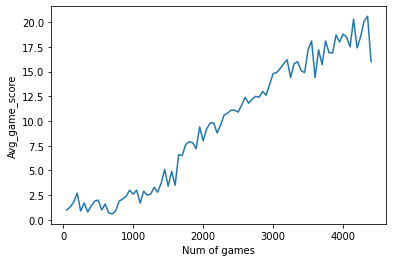

Game #4401-4410, Avg_score: 17.400, eps: 0.050: 100%|█████████▉| 499886/500000 [4:19:25<00:03, 31.02steps/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Game #4401-4410, Avg_score: 17.400, eps: 0.050: : 500005steps [4:19:30, 32.11steps/s]

Finished!


In [ ]:
# Finish the implementation and run it!
# Finish the implementation and run it!
# Finish the implementation and run it!

% matplotlib inline

list_num_game = []
list_avg_game_score = []

# Main Loop of training
num_game = 0
state = env.reset()
remaining_lives = 5
game_score = 0
game_scores = deque([], maxlen=10)  # Store the score of the latest 10 games
game_length = 0
num_time_steps = 0

# Progress bar
with tqdm(total=args.TOTAL_STEPS, position=0, leave=True, unit="steps") as pbar:
    # Loop until total time steps has been reached
    while num_time_steps < args.TOTAL_STEPS:
        # Loop until one life is wasted
        while True:

            # Get exploration rate
            eps = update_eps(num_time_steps)

            # Rollout
            with torch.no_grad():

                ## TODO ##
                ### Your code starts here ###

                # Generate replay buffer(named as memory)
                ts_state = torch.tensor(state,dtype=torch.float)
                action = select_action(ts_state,eps)
                transition = env.step(action)
                memory.push(state, action.cpu().numpy(), transition[0],transition[1],transition[2])
                state = transition[0]
                reward = transition[1]
                done = transition[2]

                # print('\ndone\n',done)
                # print('\nremaining_lives\n',transition[3][0])
                # print('\nremaining_lives\n',remaining_lives)
                ### Your code ends here ###

                # Update game score and length and total time steps
                game_score += reward
                game_length += 1
                num_time_steps += 1

            # Optimize model
            if num_time_steps % args.TRAIN_FREQ == 0:
                optimize_model()

            # Update the target network
            if num_time_steps % args.TARGET_UPDATE_INTERVAL == 0:
                target_net.load_state_dict(policy_net.state_dict())

            # One life is wasted
            if done: 
                remaining_lives = transition[3][0]["ale.lives"]
                break

        # When one game is over, i.e. all 5 lives are wasted
        if remaining_lives == 0:
            #print("HERE!")
            num_game += 1
            pbar.update(game_length)

            # Print some result in the progress bar for every 10 games
            if num_game % 10 == 0:
                #print("HERE")
                pbar.set_description(
                    "Game #{}-{}, Avg_score: {:.3f},"
                    " eps: {:.3f}".format(num_game - 9, num_game, np.asarray(
                        game_scores).mean(), eps))

            # Plot the average reward curve for every 50 games              
            if num_game % 50 == 0:
                list_num_game.append(num_game)
                list_avg_game_score.append(np.asarray(game_scores).mean())
                show_avg_reward(list_num_game, list_avg_game_score)

            # Reset game score and length
            game_scores.append(game_score)
            game_score = 0
            game_length = 0
    pbar.update(game_length)
    print("Finished!")


## Self-test question: Where and how can we change the model to get a Double DQN?

> modify function optimize_model as follows:
```python
with torch.no_grad():
    new_action_b = torch.argmax(policy_net(next_state_b[done_b!=True]), dim=1)
    temp = target_net(next_state_b[done_b!=True])
    q_sp_ap[done_b!= True] = torch.gather(input=temp, dim=1, index=new_action_b)
```